In [1]:
import glob
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

# Kimchi Premium

Same tokens are listed on multiple exchanges, and are not subjected to Reg NMS, colloquially known as One Price Law. Therefore token prices can and do differ across markets. This presents the question: what is the price of a token? Before attempting to arrive at an answer, we first examine the extent of price divergence by focusing on a famous example of BTC price difference on US and KOR exchanges, known as the "kimchi premium." We then make a case for the stationarity of the US-KOR BTC price spread, which is necessary for the idea of one price in different markets. Finally we present a simple theoretical arbitrage over the "kimchi premium".

## 1. Data Import

We import and plot 2018 BTC open, high, low, close, and volume data from:
- Upbit (KOR)
- Bitstamp (UK)
- Bitflyer (JP)
- Gemini (US)

In [2]:
for file in glob.glob("data/*.csv"):
    print(file)

data/2018-kor-upbit-btc-usd.csv
data/2018-uk-bitstamp-btc-usd.csv
data/2018-jp-bitflyer-btc-usd.csv
data/2018-us-gemini-btc-usd.csv


In [3]:
cex_dict = dict()
for file in glob.glob("data/*.csv"):
    key = file.split('-')[2]
    cex_dict[key] = pd.read_csv(file, parse_dates=['Date'])

In [4]:
for key in cex_dict.keys():
    print(key)
    print(cex_dict[key].columns.values)

upbit
['Date' 'Close' 'Open' 'High' 'Low' 'Volume BTC']
bitstamp
['Date' 'Close (8 PM EST)' 'high' 'low' 'open' 'Volume BTC' 'Volume USD']
bitflyer
['Date' 'close' 'high' 'low' 'open' 'Volume BTC' 'Volume USD']
gemini
['Date' 'Close (8 PM EST)' 'high' 'low' 'open' 'Volume BTC' 'Volume USD']


In [5]:
for key in cex_dict.keys():
    cex_dict[key].columns.values[1] = 'Close'
    print(cex_dict[key].columns.values)

['Date' 'Close' 'Open' 'High' 'Low' 'Volume BTC']
['Date' 'Close' 'high' 'low' 'open' 'Volume BTC' 'Volume USD']
['Date' 'Close' 'high' 'low' 'open' 'Volume BTC' 'Volume USD']
['Date' 'Close' 'high' 'low' 'open' 'Volume BTC' 'Volume USD']


In [6]:
cex_df = cex_dict['upbit'][['Date','Close']].rename(columns={'Close':'upbit'}).set_index('Date', drop=True)
for key in list(cex_dict.keys())[-3:]:
    cex_df = pd.concat([cex_df, cex_dict[key][['Date','Close']].rename(columns={'Close':key}).set_index('Date', drop=True)], join='inner', axis=1)

cex_df = cex_df.rename(columns={'upbit':'KOR-upbit', 'bitstamp':'UK-bitstamp','bitflyer':'JP-bitflyer','gemini':'US-gemini'})

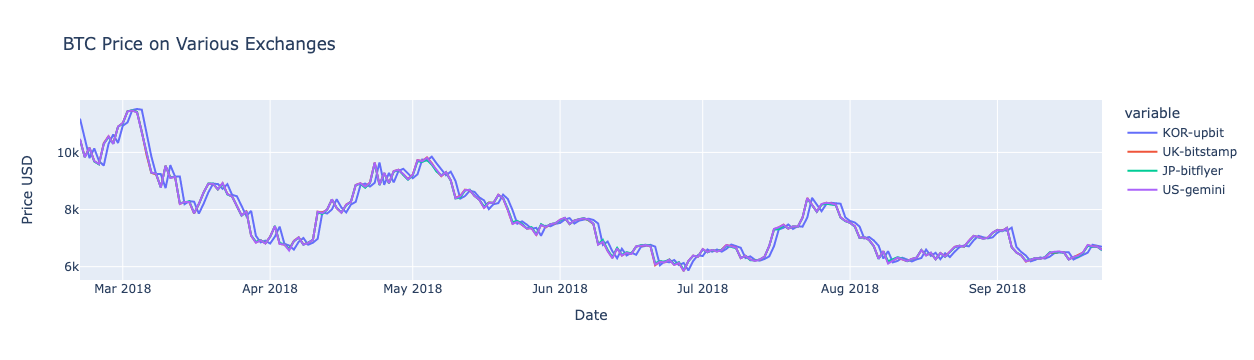

In [7]:
fig = px.line(
    cex_df, 
    x=cex_df.index, 
    y=list(cex_df.columns)[:4],
    title='BTC Price on Various Exchanges',
    labels={
        'value':'Price USD'
    }
    )
fig.update_traces(mode="lines", hovertemplate=None)
fig.update_layout(hovermode="x unified")
fig.show()

## 2. Price Deviations

We see some deviations most clearly from KOR and US exchanges in the hundreds of USDs.  To further clarify this divergence, we plot the percent change of KOR, UK, and JP BTC prices against US prices.

In [8]:
from itertools import combinations
 
key_comb = combinations(list(cex_df.keys())[::-1], 2)
 
# Print the obtained combinations
for key_pair in list(key_comb):
    key1 = key_pair[0]
    key2 = key_pair[1]
    cex_df[f'{key1.split("-")[0]}-{key2.split("-")[0]}'] = (cex_df[key1] - cex_df[key2]) / cex_df[key1]

In [9]:
cex_df

,KOR-upbit,UK-bitstamp,JP-bitflyer,US-gemini,US-JP,US-UK,US-KOR,JP-UK,JP-KOR,UK-KOR
Date,,,,,,,,,,
2018-02-20,11182.0,10449.40,10446.40,10475.00,0.002730,0.002444,-0.067494,-0.000287,-0.070417,-0.070109
2018-02-21,10444.0,9843.34,9832.23,9829.96,-0.000231,-0.001361,-0.062466,-0.001130,-0.062221,-0.061022
2018-02-22,9800.0,10166.10,10153.90,10161.62,0.000760,-0.000441,0.035587,-0.001202,0.034854,0.036012
2018-02-23,10140.0,9689.99,9682.70,9697.21,0.001496,0.000745,-0.045662,-0.000753,-0.047229,-0.046441
2018-02-24,9699.5,9590.04,9580.60,9595.00,0.001501,0.000517,-0.010891,-0.000985,-0.012410,-0.011414
...,...,...,...,...,...,...,...,...,...,...
2018-09-19,6393.9,6492.98,6478.42,6495.87,0.002686,0.000445,0.015698,-0.002247,0.013046,0.015260
2018-09-20,6491.3,6749.45,6727.00,6759.51,0.004810,0.001488,0.039679,-0.003337,0.035038,0.038248
2018-09-21,6767.0,6710.01,6691.72,6710.26,0.002763,0.000037,-0.008456,-0.002733,-0.011250,-0.008493


In [10]:
cex_df.describe()

,KOR-upbit,UK-bitstamp,JP-bitflyer,US-gemini,US-JP,US-UK,US-KOR,JP-UK,JP-KOR,UK-KOR
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,7662.535185,7641.696435,7639.334444,7640.282083,0.000004,-0.000176,-0.003205,-0.000186,-0.003184,-0.003027
std,1298.327717,1274.390903,1267.967233,1273.425454,0.002815,0.001339,0.037384,0.002727,0.036583,0.037292
min,5867.100000,5848.330000,5885.800000,5850.130000,-0.013064,-0.008268,-0.122259,-0.008722,-0.121310,-0.121977
25%,6598.300000,6583.225000,6580.355000,6576.585000,-0.001112,-0.000781,-0.021609,-0.001802,-0.021714,-0.020943
50%,7400.900000,7375.305000,7389.215000,7383.215000,0.000247,-0.000133,0.000849,-0.000348,0.000931,-0.000960
75%,8435.250000,8422.040000,8408.852500,8414.807500,0.001541,0.000471,0.015063,0.001221,0.016718,0.015910
max,11520.000000,11463.270000,11481.000000,11467.190000,0.009140,0.007185,0.119488,0.011284,0.117838,0.119865


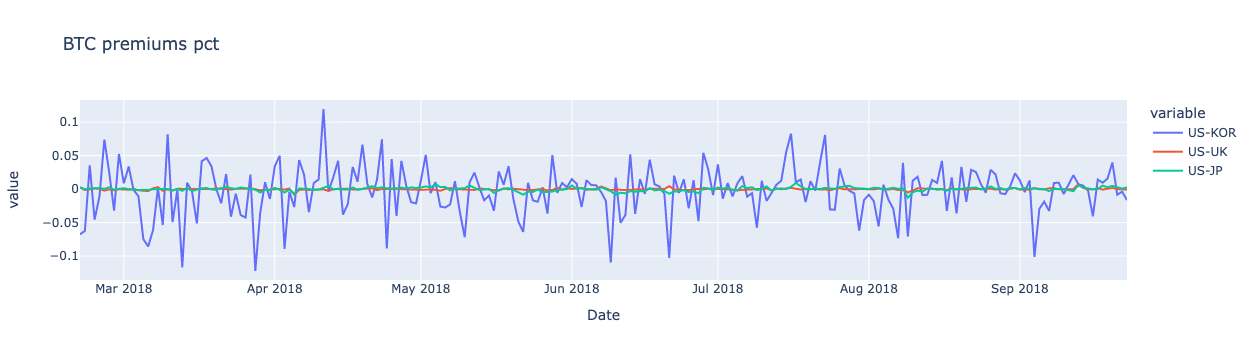

In [11]:
fig = px.line(cex_df, x=cex_df.index, y=list(cex_df.columns)[4:7][::-1], title='BTC premiums pct')
fig.update_traces(mode="lines", hovertemplate=None)
fig.update_layout(hovermode="x unified")
fig.show()

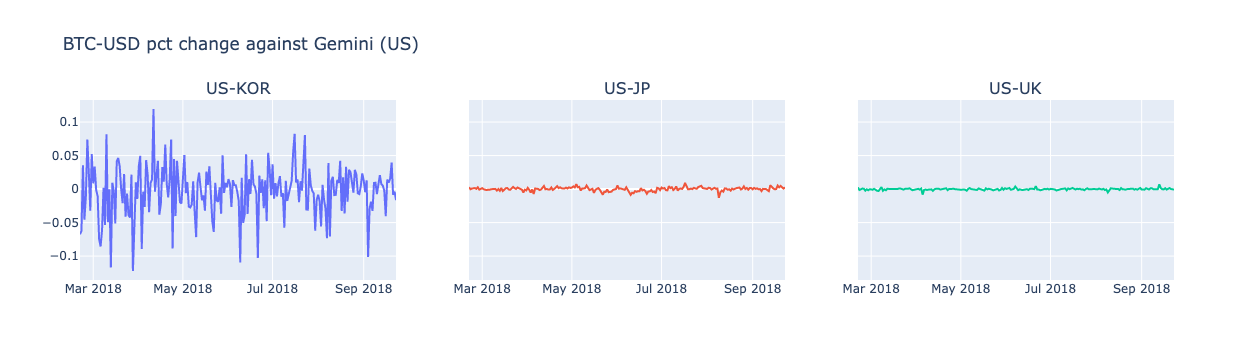

In [12]:
fig = make_subplots(
    rows=1, cols=3, 
    shared_yaxes=True,
    subplot_titles=("US-KOR","US-JP", "US-UK")
)
fig.add_trace(
    go.Scatter(x=cex_df.index, y=cex_df['US-KOR'],name='US-KOR'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=cex_df.index, y=cex_df['US-JP'],name='US-JP'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=cex_df.index, y=cex_df['US-UK'],name='US-UK'),
    row=1, col=3
)
fig.update_layout(title_text="BTC-USD pct change against Gemini (US)", showlegend=False)
fig.show()

We observe significant volatility in US-KOR spread versus US-JP and US-UK. The Kimchi Premium (US-KOR) during 2018 reached a maximum of +/-12% with 3.7% volatility, a significantly divergence in price. We will use US-KOR spread for rest of this notebook. 

## 3. Testing for Stationarity

Stationarity of BTC price spreads is a necessary condition for the possibility of a single price across markets. Stationarity means a series reverts to some constant.

To illustrate, suppose we are tasked with finding a single price for BTC and synthetic BTC products such as Grayscale BTC trust fund, which technically tracks the underlying. GBTC is currently trading some 40% below BTC since Q3 2022 when 3AC imploded. BTC-GBTC in 2022 is not stationary for extended period of months, and therefore does not warrant a single price given that price is neither informative nor actionable.

### Dickey-Fuller Test with OLS Regression

To test for the stationarity of US-KOR spread, which is an autoregressive time series, we will use a simplified **Dickey-Fuller (DF) test** with 100 observations with the following hypotheses:
- null hypothesis: there is a unit root (US-KOR spread is not stationary)
- alternative hypothesis: US-KOR spread is  stationary.

To perform the simple DF test, we use ordinary least squares regression model, and regress next day spread delta with current day spread. The idea is that if a series is stationary, then prices should oscillate from some constant, and not be subjected to random walk. In the case of DF test, we compare t statistic with 100 samples to the DF t stat table to determine whether to reject the null hypothesis.

In [13]:
kimchi_df = cex_df[['KOR-upbit','US-gemini','US-KOR']]
kimchi_df = kimchi_df.rename(columns={'US-KOR':'US-KOR-pct'})
kimchi_df['US-KOR-spread'] = kimchi_df['US-gemini'] - kimchi_df['KOR-upbit']
kimchi_df['US-KOR-delta'] = kimchi_df['US-KOR-spread'].shift(-1) - kimchi_df['US-KOR-spread']
kimchi_df['US-KOR-delta'] = kimchi_df['US-KOR-delta'].shift(1)
display(kimchi_df)

,KOR-upbit,US-gemini,US-KOR-pct,US-KOR-spread,US-KOR-delta
Date,,,,,
2018-02-20,11182.0,10475.00,-0.067494,-707.00,NaN
2018-02-21,10444.0,9829.96,-0.062466,-614.04,92.96
2018-02-22,9800.0,10161.62,0.035587,361.62,975.66
2018-02-23,10140.0,9697.21,-0.045662,-442.79,-804.41
2018-02-24,9699.5,9595.00,-0.010891,-104.50,338.29
...,...,...,...,...,...
2018-09-19,6393.9,6495.87,0.015698,101.97,41.55
2018-09-20,6491.3,6759.51,0.039679,268.21,166.24
2018-09-21,6767.0,6710.26,-0.008456,-56.74,-324.95


In [14]:
def linearRegression(df, samples):
    training_df = df[:samples+1].copy()
    # spread
    target = training_df['US-KOR-spread']
    # delta, use shift(-1) to have spread lag one day behind delta 
    features = training_df['US-KOR-delta'].shift(-1)
    # avoid NaN
    X = features[:-1]
    y = target[:-1]
    # add constant
    X_pred = sm.add_constant(X)
    model = sm.OLS(y, X_pred)
    results = model.fit()
    # print(results.summary())
    return y, X, results

In [15]:
train_y, train_X, results = linearRegression(kimchi_df, 100)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          US-KOR-spread   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     107.1
Date:                Wed, 15 Mar 2023   Prob (F-statistic):           2.10e-17
Time:                        11:54:05   Log-Likelihood:                -696.20
No. Observations:                 100   AIC:                             1396.
Df Residuals:                      98   BIC:                             1402.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -34.5821     25.809     -1.340   

### Dickey-Fuller Table

R-squared here is not critical given we are not looking to establish an accurate prediction from spread to delta. VIF doesn't apply given we are looking at a single variable. The t stat or p value matters with respect to our null hypothesis (series is not stationary) interpreted through the Dickey-Fuller table:

|                          | critical | t stat (n=100) |
|--------------------------|----------|----------------|
| w/ constant              |          |                |
|                          | 2%       | -3.51          |
|                          | 5%       | -3.17          |
|                          | 10%      | -2.58          |
| w/ constant + time trend |          |                |
|                          | 2%       | -4.04          |
|                          | 5%       | -3.69          |
|                          | 10%      | -3.15          |

With t stat of -10.35 for the variable less than -4.04 for time trend series with 100 observations, we have evidence to reject the null hypothesis that US-KOR is not stationary.

### Analysis of Residuals

We perform standard analysis and diagnostics of residuals to determine the validity of using OLS regression.

In [16]:
predicted = results.predict()
pred = results.get_prediction()
pred_df = pred.summary_frame()
resid_df = pd.concat([kimchi_df, pred_df.shift(1)], axis=1, join="inner")
resid_df = resid_df.rename(columns={"mean": "delta_pred", 
                                    "obs_ci_lower": "prediction_lower", 
                                    "obs_ci_upper": "prediction_upper",
                                    "mean_ci_lower": "confidence_lower",
                                    "mean_ci_upper": "confidence_upper"})
# display(resid_df)

In [17]:
resid_df.describe()

,KOR-upbit,US-gemini,US-KOR-pct,US-KOR-spread,US-KOR-delta,delta_pred,mean_se,confidence_lower,confidence_upper,prediction_lower,prediction_upper
count,100.000000,100.000000,100.000000,100.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,8649.517000,8611.235700,-0.004956,-38.281300,7.826667,-38.559024,34.963802,-107.943550,30.825503,-555.786158,478.668111
std,1193.171345,1161.803596,0.042716,371.468441,530.973540,269.800383,10.830949,269.527842,271.777833,269.522708,270.127381
min,6597.400000,6564.060000,-0.122259,-959.080000,-1500.880000,-670.367142,25.814371,-801.933664,-538.800619,-1199.116041,-141.618242
25%,7888.525000,7874.702500,-0.032715,-257.777500,-327.120000,-206.902188,27.196722,-267.465199,-146.339177,-722.589622,308.785245
50%,8561.000000,8527.750000,-0.002328,-21.155000,-12.840000,-28.057795,30.540534,-79.307173,23.191583,-542.734536,486.618946
75%,9331.250000,9298.940000,0.022019,178.152500,339.130000,131.635406,38.282260,70.908909,192.361903,-384.072684,647.343496
max,11520.000000,11467.190000,0.119488,946.390000,1251.240000,728.050996,78.408255,572.452366,883.649626,192.815923,1263.286068


#### Prediction and Confidence Intervals

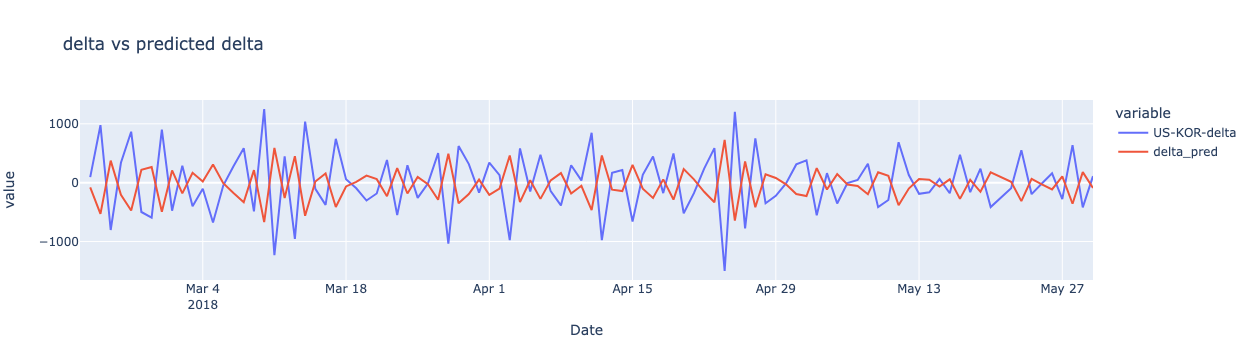

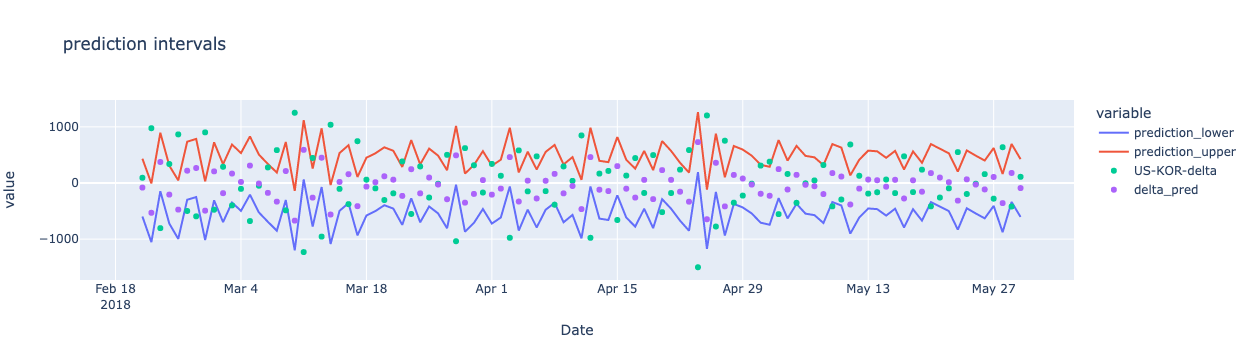

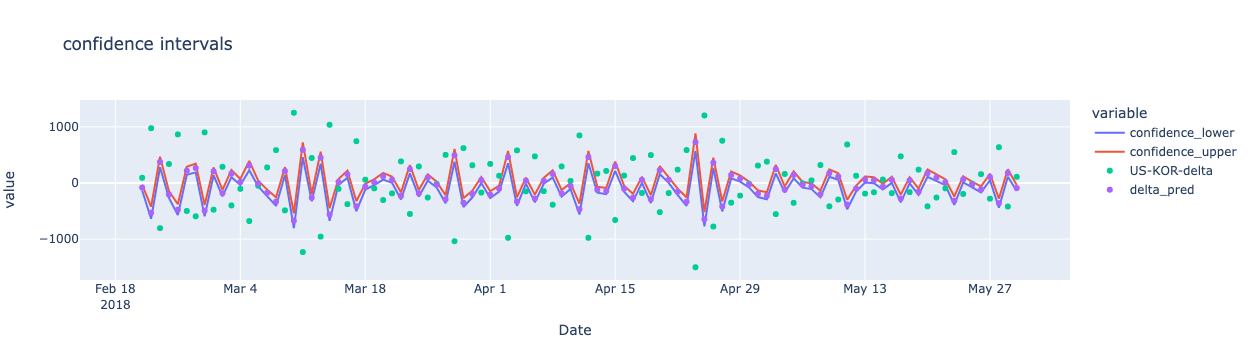

In [18]:
fig = px.line(
    resid_df, 
    x=resid_df.index, 
    y=['US-KOR-delta','delta_pred'],
    title='delta vs predicted delta')
fig.show()

fig = px.line(
    resid_df, 
    x=resid_df.index, 
    y=[
        # 'confidence_lower',
        # 'confidence_upper',
        'prediction_lower',
        'prediction_upper'
    ],
    title='prediction intervals'
)
fig.add_scatter(
    x=resid_df.index, 
    y=resid_df['US-KOR-delta'], mode='markers', name='US-KOR-delta')
fig.add_scatter(
    x=resid_df.index, 
    y=resid_df['delta_pred'], mode='markers',name='delta_pred')
fig.show()

fig = px.line(
    resid_df, 
    x=resid_df.index, 
    y=[
        'confidence_lower',
        'confidence_upper',
    ],
    title='confidence intervals'
)
fig.add_scatter(
    x=resid_df.index, 
    y=resid_df['US-KOR-delta'], mode='markers', name='US-KOR-delta')
fig.add_scatter(
    x=resid_df.index, 
    y=resid_df['delta_pred'], mode='markers',name='delta_pred')
fig.show()


We see that intervals are stationary and very large values in prediction intervals as expected given correlation coefficient.

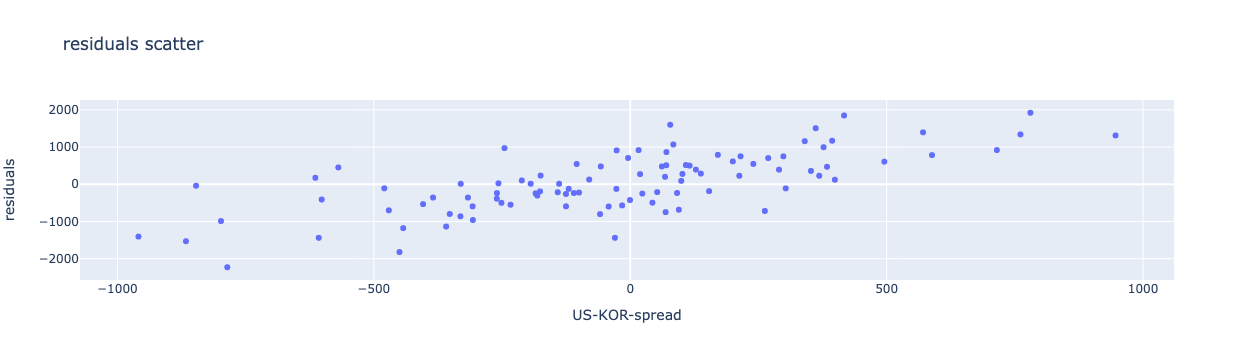

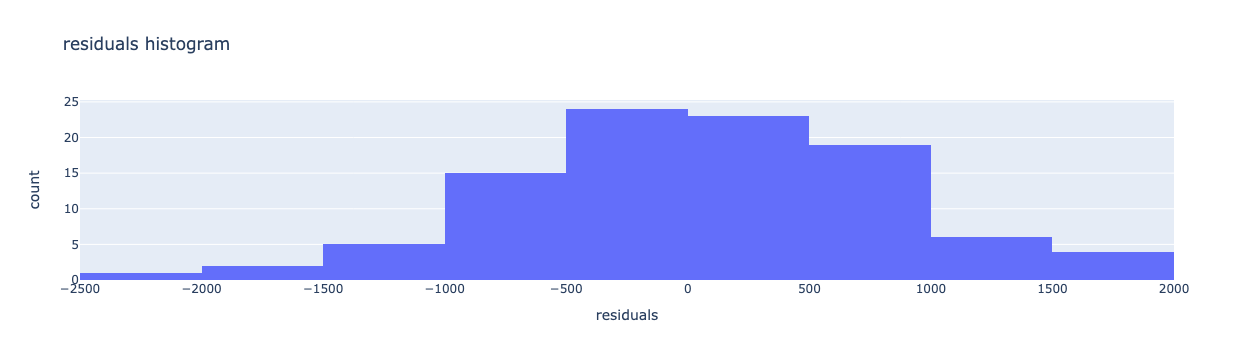

In [19]:
resid_df['residuals'] = resid_df['US-KOR-delta'] - resid_df['delta_pred']

fig = px.scatter(
    resid_df, 
    x=resid_df['US-KOR-spread'], 
    y=resid_df['residuals'],
    title='residuals scatter')
fig.show()

fig = px.histogram(resid_df, x="residuals", title='residuals histogram')
fig.show()

In [20]:
%%capture
qqplot_resids = qqplot(resid_df['residuals'], line='').gca().lines;

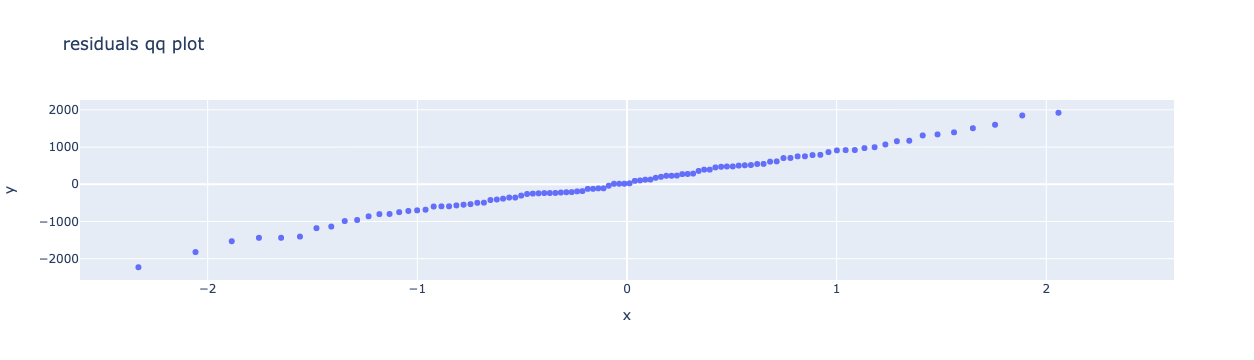

In [21]:
fig = px.scatter(
    x= qqplot_resids[0].get_xdata(),
    y= qqplot_resids[0].get_ydata(),
    title='residuals qq plot'
)

fig.show()

Distribution of residuals do not show significant outliers or leverage points, though exhibits non-randomness from scatter plot as expected. Next steps could be additional diagnostics with Cook's for example to pinpoint influence and leverage points. In this case I believe there is ample evidence for the stationarity of US-KOR BTC price spreads, which clears the path for one price aggregation as well as theoretical CEX arbitrage, which we will briefly explore.

## 4. Spread Arbitrage

We split training and testing data as follows:

| Data Select | In                            | Out                      |
|-------------|-------------------------------|--------------------------|
| Time        | 2018-02-20 to 2018-05-31 (DF) | 2018-06-01 to 2018-09-23 |
| Universe    | N/A                           | N/A                      |

In-time sample is the same data set used to determine stationarity with OLS, so we will train our strategies on that sample. 

### Instant Two-Sided Arbitrage

For simplicity, we assume
- two traders, one in the US, the other in Korea, going long/short BTC for full portfolio value
- both traders have access to the same BTC wallet starting with 1 BTC and same USD funding account
- trades are executed instantly at the indicated price at the same time and netted once per day

These conditions effectively makes long/short in both markets to be equivalent to arbitraging the spread.

For example, on 2018-02-20, KOR trader sells 1xBTC for 11182, US trader buys 1xBTC for 10475, netting 707 in profits.

Signal:
- If US < KOR: long US / short KOR 
- If US > KOR: short US / long KOR
- If US = KOR: hold

Effectively:
- If US - KOR < 0, spread multiply -1
- if US - KOR > 0, spread multiply 1

In [22]:
def instantArbitrage(df):
    # creat signals
    df.insert(len(df.columns),'signal-US',np.zeros(len(df))) 
    df.loc[df['US-KOR-spread'] < 0, 'signal-US'] = -1
    df.loc[df['US-KOR-spread'] > 0, 'signal-US'] = 1
    df.loc[df['US-KOR-spread'] == 0, 'signal-US'] = 0
    df['signal-KOR'] = df['signal-US']*-1
    
    # create arbitrage profit
    df['arb1'] = (df['signal-US']*df['US-gemini']) + (df['signal-KOR']*df['KOR-upbit'])
    
    # calculate cumulative profit
    arb_profit = 0
    arb_cum = []
    for arb in df['arb1']:
        arb_profit += arb
        arb_cum.append(arb_profit)

    return arb_cum

In [30]:
train_df['US-gemini'].index[0]

Timestamp('2018-02-20 00:00:00', freq='D')

In [40]:
def performanceSummary(series):
    # annualized daily sharpe
    absolute_ret = series[-1] / series[0] - 1
    dret = [i / j - 1 for i, j in zip(series[1:], series[:-1])]
    mean_dret = np.mean(dret)
    vol_dret = np.std(dret)
    dsharpe = mean_dret / vol_dret
    annualized_dsharpe = dsharpe * (365**0.5)
    # annualized log daily sharpe
    ln_dret = [np.log(i / j) for i, j in zip(series[1:], series[:-1])]
    mean_ln_dret = np.mean(ln_dret)
    vol_ln_dret = np.std(dret)
    lnsharpe = mean_ln_dret / vol_ln_dret
    annualized_lnsharpe = lnsharpe * (365**0.5)
    
    print(f'''
    {series.name}
    {series.index[0]} to {series.index[-1]}
    {len(series.index)} days
    LOG RETURNS:
        annualized sharpe: {annualized_lnsharpe}
        average daily log ret: {mean_dret}
        vol daily log ret: {vol_dret}
    SIMPLE RETURNS:
        annualized sharpe: {annualized_dsharpe}
        average daily ret: {mean_ln_dret}
        vol daily ret: {vol_ln_dret}
    ''')



    arbitrage
    2018-02-20 00:00:00 to 2018-05-31 00:00:00
    101 days
    LOG RETURNS:
        annualized sharpe: 7.010209512915921
        average daily log ret: 0.041351874349167615
        vol daily log ret: 0.10088702874369264
    SIMPLE RETURNS:
        annualized sharpe: 7.830803027860045
        average daily ret: 0.03701859207901144
        vol daily ret: 0.10088702874369264
    

    US-gemini
    2018-02-20 00:00:00 to 2018-05-31 00:00:00
    101 days
    LOG RETURNS:
        annualized sharpe: -1.512440067585346
        average daily log ret: -0.0024314968541335846
        vol daily log ret: 0.04184831085427638
    SIMPLE RETURNS:
        annualized sharpe: -1.1100491566784552
        average daily ret: -0.0033129102835439597
        vol daily ret: 0.04184831085427638
    

    KOR-upbit
    2018-02-20 00:00:00 to 2018-05-31 00:00:00
    101 days
    LOG RETURNS:
        annualized sharpe: -1.798703374264078
        average daily log ret: -0.003084022250553633
        v

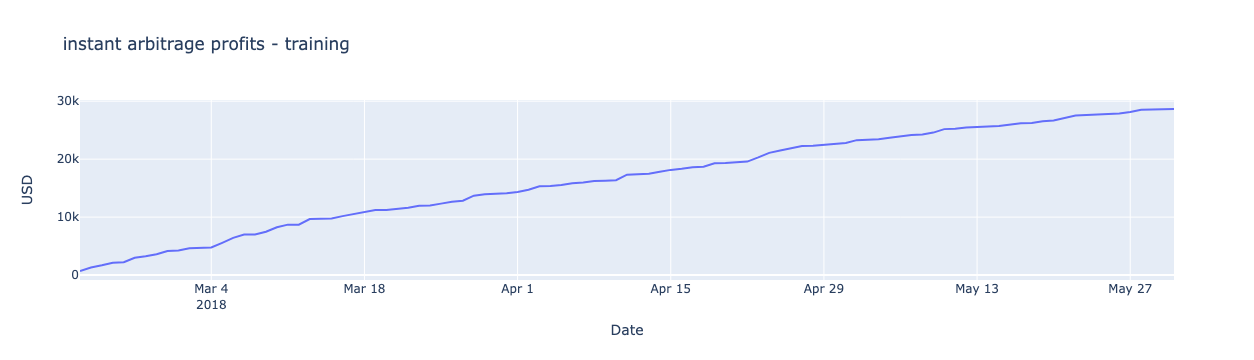

In [41]:
train_df = kimchi_df[:101].copy()
train_arb_cum = instantArbitrage(train_df)
performanceSummary(pd.Series(train_arb_cum, index=train_df.index, name='arbitrage'))
performanceSummary(train_df['US-gemini'])
performanceSummary(train_df['KOR-upbit'])
fig = px.line(
    x=train_df.index, 
    y=train_arb_cum, 
    title='instant arbitrage profits - training',
    labels={
        "x":'Date',
        "y":'USD'
    }
)
fig.show()

To do:
Apply to other spreads + test (no need really, this is instantenous arbitrage)


    arbitrage
    2018-06-01 00:00:00 to 2018-09-23 00:00:00
    115 days
    LOG RETURNS:
        annualized sharpe: 5.563635605227028
        average daily log ret: 0.0529829698403704
        vol daily log ret: 0.1529795075211374
    SIMPLE RETURNS:
        annualized sharpe: 6.616822304569285
        average daily ret: 0.04454977388027995
        vol daily ret: 0.1529795075211374
    

    US-gemini
    2018-06-01 00:00:00 to 2018-09-23 00:00:00
    115 days
    LOG RETURNS:
        annualized sharpe: -0.7860094542111323
        average daily log ret: -0.0007957694307437046
        vol daily log ret: 0.031704675264440985
    SIMPLE RETURNS:
        annualized sharpe: -0.4795240292062247
        average daily ret: -0.0013043815488707595
        vol daily ret: 0.031704675264440985
    

    KOR-upbit
    2018-06-01 00:00:00 to 2018-09-23 00:00:00
    115 days
    LOG RETURNS:
        annualized sharpe: -0.6217729939103247
        average daily log ret: -0.0005227105487267125
        

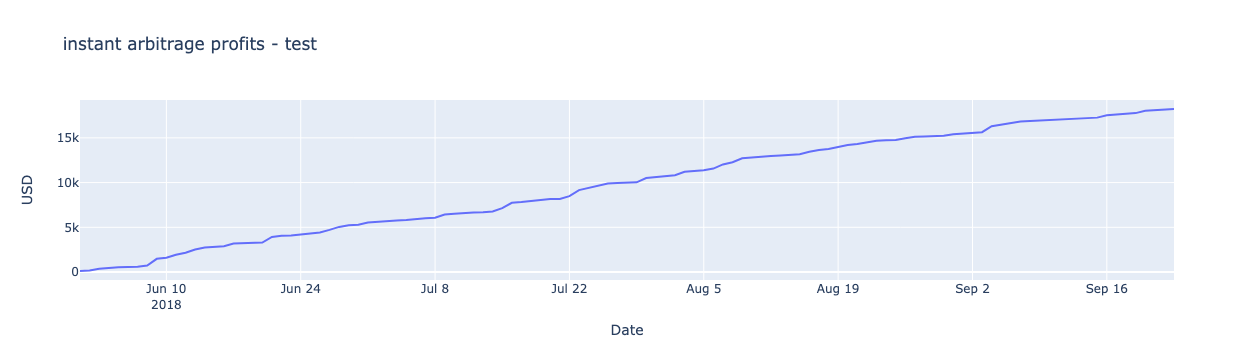

In [42]:
test_df = kimchi_df[101:].copy()
test_arb_cum = instantArbitrage(test_df)
performanceSummary(pd.Series(test_arb_cum, index=test_df.index, name='arbitrage'))
performanceSummary(test_df['US-gemini'])
performanceSummary(test_df['KOR-upbit'])
fig = px.line(
    x=test_df.index, 
    y=test_arb_cum, 
    title='instant arbitrage profits - test',
    labels={
        "x":'Date',
        "y":'USD'
    }
)
fig.show()